In [39]:
import os
import pandas as pd
from collections import Counter, defaultdict
from tqdm import tqdm
import random
import re
import sys

import numpy as np
from numpy import nan
from sklearn import cluster
from matplotlib import pyplot as plt
from itertools import chain, combinations

sys.path.append("analysis/")
from analysis import load_results

pd.set_option('display.max_colwidth', 280)
pd.set_option('expand_frame_repr', False)

In [2]:
many_names_path = "proc_data_phase0/verification/all_responses_round0-3_verified_new.csv"
manynames = load_results.load_cleaned_results(many_names_path)

In [49]:
manynames["vg_obj_name_spellchecked"] = manynames["vg_obj_name"].apply(lambda a: re.sub("(.+)\.$", r"\1", a))

### Inspection of data

In [3]:
manynames.columns

Index(['vg_image_id', 'cat', 'synset', 'vg_obj_name', 'responses_r0',
       'opt-outs', 'vg_domain', 'top_response_domain_r0',
       'responses_domains_r0', 'url', 'sample_type', 'responses_domains_r1',
       'responses_r1', 'top_response_domain_r1', 'responses_domains_r2',
       'responses_r2', 'top_response_domain_r2', 'responses_domains_r3',
       'responses_r3', 'top_response_domain_r3', 'vg_object_id',
       'all_responses', 'clean', 'canon', 'spellchecked', 'spellchecked_min2',
       'adequacy_mean', 'inadequacy_type', 'same_object', 'vg_adequacy_mean',
       'vg_inadequacy_type', 'vg_same_object'],
      dtype='object')

In [99]:
manynames[manynames["vg_adequacy_mean"]<0.1][["vg_inadequacy_type"]]

,vg_inadequacy_type
925,{'visual': 1.0}
1138,{'other': 1.0}
1582,{'other': 1.0}
2919,"{'other': 0.3, 'visual': 0.7}"
3329,"{'visual': 0.3, 'other': 0.7}"
3652,{'other': 1.0}
3733,{'other': 1.0}
4665,"{'bounding box': 0.3, 'visual': 0.3, 'other': 0.3}"
5554,{'visual': 1.0}
5772,"{'other': 0.7, 'bounding box': 0.3}"


In [5]:
rowid = 0 # 25309 # 71 # 89
bbox_issue = int(manynames.iloc[rowid]["vg_inadequacy_type"].get('bounding box', 0) > 0)
other_issue = len(set(manynames.iloc[rowid]["vg_inadequacy_type"].keys()).intersection(["visual", "linguistic", "other"])) > 0
print(other_issue, bbox_issue)

False 0


In [6]:
responses = manynames[["vg_image_id", 'spellchecked_min2']].query("vg_image_id == 84")["spellchecked_min2"].values[0]
total_count = np.sum(list(responses.values()))
{a[0]:"%.2f"%(a[1]/total_count) for a in responses.items()}.items()

dict_items([('chair', '0.28'), ('bed', '0.25'), ('couch', '0.22'), ('pillow', '0.12'), ('bed cover', '0.06'), ('sofa', '0.06')])

In [7]:
manynames[["vg_image_id", 'vg_same_object', "same_object", 'spellchecked_min2', 'adequacy_mean', 'vg_obj_name', 'vg_adequacy_mean']].query("vg_image_id == 84")

,vg_image_id,vg_same_object,same_object,spellchecked_min2,adequacy_mean,vg_obj_name,vg_adequacy_mean
15177,84,"{'bed cover': 0.33, 'chair': 0.67, 'bed': 1.0, 'sofa': 0.67, 'pillow': 0.0, 'couch': 0.67}","{'bed': {'bed cover': 0.33, 'chair': 0.67, 'bed': 1.0, 'sofa': 0.67, 'pillow': 0.0, 'couch': 0.67}, 'pillow': {'bed cover': 0.0, 'chair': 0.0, 'bed': 0.0, 'sofa': 0.0, 'pillow': 1.0, 'couch': 0.0}, 'couch': {'bed cover': 0.0, 'chair': 1.0, 'bed': 0.67, 'sofa': 1.0, 'pillow': ...","{'chair': 9, 'bed': 8, 'couch': 7, 'pillow': 4, 'bed cover': 2, 'sofa': 2}","{'bed': 0.83, 'pillow': 0.33, 'couch': 0.33, 'sofa': 0.33, 'chair': 0.33, 'bed cover': 0.5}",bed,0.83


### Basic statistics

In [8]:
min_topCount = 36
min_topMN = ""
distr_counts = defaultdict(int)
for (_, row) in manynames.iterrows():
    (topMN, topCount) = row['spellchecked'].most_common()[0]
    distr_counts[topCount] += 1
    if min_topCount > topCount:
        min_topCount = topCount
        min_topMN = topMN

In [9]:
print("Minimum count of topMN names (over all instances): %d (%s)" % (min_topCount, min_topMN))
print("Distribution: ", distr_counts)
total_num = sum(distr_counts.values())
cum_sum = 0
minCounts = list(distr_counts.keys())
minCounts.sort()
for minCnt in minCounts:
    cum_sum += distr_counts[minCnt]
    print("min count <= %d --- %.3f%% of instances." % (minCnt, cum_sum/total_num*100))

Minimum count of topMN names (over all instances): 4 (runway)
Distribution:  defaultdict(<class 'int'>, {11: 455, 14: 647, 32: 1313, 36: 906, 26: 944, 15: 689, 33: 1274, 29: 1151, 24: 863, 31: 1310, 35: 1247, 27: 1032, 23: 895, 28: 1016, 17: 880, 16: 790, 34: 1277, 18: 912, 13: 592, 19: 878, 21: 861, 25: 853, 12: 551, 30: 1228, 20: 885, 22: 879, 6: 31, 10: 384, 8: 190, 9: 291, 5: 7, 7: 80, 4: 4})
min count <= 4 --- 0.016% of instances.
min count <= 5 --- 0.043% of instances.
min count <= 6 --- 0.166% of instances.
min count <= 7 --- 0.482% of instances.
min count <= 8 --- 1.232% of instances.
min count <= 9 --- 2.382% of instances.
min count <= 10 --- 3.899% of instances.
min count <= 11 --- 5.696% of instances.
min count <= 12 --- 7.873% of instances.
min count <= 13 --- 10.211% of instances.
min count <= 14 --- 12.767% of instances.
min count <= 15 --- 15.489% of instances.
min count <= 16 --- 18.610% of instances.
min count <= 17 --- 22.086% of instances.
min count <= 18 --- 25.688%

## Adequacy against response probability

In [10]:
def relfrequ(responses):
    total = sum(responses.values())
    return {a[0]:(a[1]/total) for a in responses.items()}

In [11]:
def func_adequacy_probability(data_stats):    
    datastats_df = pd.DataFrame()
    datastats_df["mean_adequacy"] = np.array(data_stats)[:,0]
    datastats_df["mn_probability"] = np.array(data_stats)[:,1]
    #bins = pd.cut(np.array(list(set(datastats_df['mean_adequacy'].values))), 10)
    datastats_df["bins"] = pd.cut(datastats_df['mean_adequacy'], [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    data_func_vals = []
    data_bin_sizes = []
    for a in datastats_df.groupby(by=["bins"]):
        data_func_vals.append((a[0], np.mean(a[1]["mn_probability"].values)))
        data_bin_sizes.append((a[0], len(a[1]["mean_adequacy"].values)))
    return data_func_vals, data_bin_sizes
    

In [12]:
def func_adequacy_probability_observations(data_stats):    
    datastats_df = pd.DataFrame()
    datastats_df["mean_adequacy"] = np.array(data_stats)[:,0]
    datastats_df["mn_probability"] = np.array(data_stats)[:,1]
    #bins = pd.cut(np.array(list(set(datastats_df['mean_adequacy'].values))), 10)
    datastats_df["bins"] = pd.cut(datastats_df['mean_adequacy'], [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    data_func_vals = []
    data_bin_sizes = []
    for a in datastats_df.groupby(by=["bins"]):
        data_func_vals.append((a[0], np.mean(a[1]["mn_probability"].values)))
        data_bin_sizes.append((a[0], len(a[1]["mean_adequacy"].values)))
    return data_func_vals, data_bin_sizes, datastats_df

In [13]:
def func_probability_adequacy(data_stats):    
    datastats_df = pd.DataFrame()
    datastats_df["mean_adequacy"] = np.array(data_stats)[:,0]
    datastats_df["mn_probability"] = np.array(data_stats)[:,1]
    datastats_df["bins"] = pd.cut(datastats_df['mn_probability'], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    data_func_vals = []
    data_bin_sizes = []
    for a in datastats_df.groupby(by=["bins"]):
        mean_adequacies = a[1]["mean_adequacy"].values
        avg_mean_adscore = np.mean(mean_adequacies) if len(mean_adequacies) > 0 else 0.0
        data_func_vals.append((a[0], avg_mean_adscore))
        data_bin_sizes.append((a[0], len(a[1]["mn_probability"].values)))
    return data_func_vals, data_bin_sizes
    

## topMN vs. VG name

In [65]:
#manynames["vg_obj_name_spellchecked"] = manynames["vg_obj_name"].apply(lambda a: re.sub("(.+)\.$", r"\1", a))
#manynames["vg_obj_name_orig"] = manynames["vg_obj_name"]
#manynames["vg_obj_name"] = manynames["vg_obj_name_spellchecked"]
manynames["vg_obj_name"] = manynames["vg_obj_name_orig"]

In [74]:
num_lowcount_vgname = 0
num_notgiven_vgname = 0
num_low_count_bbox = 0
num_notgiven_bbox = 0
num_low_count_other = 0
num_notgiven_other = 0

all_mnprob_topMN = []
all_mnprob_vg = []
topMN_same_as_vg = []
all_adequ_topMN = []
all_adequ_vg = []
all_topMN = []
all_vg_name = []
all_vg_count = []
all_vg_bbox = []
all_vg_otherinad = []
all_vg_noinad = []

fout_vg_notinmn = open("vg_not-in-mn.txt", "w")

for (_, row) in manynames.iterrows():
    (topMN, topCount) = row['spellchecked'].most_common()[0]
    mn_nameProbs = relfrequ(row['spellchecked_min2'])
    low_counts = set(row['spellchecked']).difference(set(row['spellchecked_min2']))
    vg_name = row['vg_obj_name']
    adequacy_topMN = row['adequacy_mean'][topMN]
    adequacy_vg = row['vg_adequacy_mean']
    sameobj_topMN = row["same_object"][topMN]
    sameobj_vg = row['vg_same_object']
    if topMN != vg_name:
        #print(topMN, vg_name, adequacy_topMN, adequacy_vg, mn_nameProbs, low_counts)
        mnprob_vg = mn_nameProbs.get(vg_name, 0.0)
        bbox_issue = int(row["vg_inadequacy_type"].get('bounding box', 0) > 0)
        other_issue = int(len(set(row["vg_inadequacy_type"].keys()).intersection(["visual", "linguistic", "other"])) > 0)
        # VG in MN, but given only once
        if vg_name in low_counts:
            num_lowcount_vgname += 1
            num_low_count_bbox += bbox_issue
            all_vg_count.append(1)
        # VG not given at all
        elif vg_name not in mn_nameProbs:
            num_notgiven_vgname += 1
            num_notgiven_bbox += bbox_issue
            all_vg_count.append(0)
            fout_vg_notinmn.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (
                vg_name, str(adequacy_vg), str(row["vg_inadequacy_type"]), topMN, str(adequacy_topMN), 
                row["url"], str(row['spellchecked'])))
        else:
            all_vg_count.append(row['spellchecked'][vg_name])
        all_topMN.append(topMN)
        all_vg_name.append(vg_name)
        all_mnprob_topMN.append(mn_nameProbs.get(topMN))
        all_mnprob_vg.append(mn_nameProbs.get(vg_name, 0.0))
        all_adequ_topMN.append(adequacy_topMN)
        all_adequ_vg.append(adequacy_vg)
        topMN_same_as_vg.append(sameobj_vg.get(topMN))
        all_vg_bbox.append(bbox_issue)
        all_vg_otherinad.append(other_issue)

fout_vg_notinmn.close()

In [75]:
total = len(all_vg_count)
num_in_mn = total-(num_notgiven_vgname+num_lowcount_vgname)
print("No. VG names not in MN: %d (%.2f%% // complete MN: %.2f%%)" % (num_notgiven_vgname, 
                                                                      num_notgiven_vgname/total*100,
                                                                      num_notgiven_vgname/len(manynames)*100))
print("No. VG names with MN count=1:  %d (%.2f%% // complete MN: %.2f%%)" % (num_lowcount_vgname, 
                                                                             num_lowcount_vgname/total*100,
                                                                             num_lowcount_vgname/len(manynames)*100))
print("Rest:  %d (%.2f%% // complete MN: %.2f%%)" % (num_in_mn, 
                                                     num_in_mn/total*100,
                                                     num_in_mn/len(manynames)*100))
print("No. VG names != topMN: %d / %d (%.2f%%)" % (total, len(manynames), total/len(manynames)*100))

No. VG names not in MN: 1938 (28.11% // complete MN: 7.66%)
No. VG names with MN count=1:  830 (12.04% // complete MN: 3.28%)
Rest:  4126 (59.85% // complete MN: 16.30%)
No. VG names != topMN: 6894 / 25315 (27.23%)


##### "." NOT removed at the end of the VG names:
* No. VG names not in MN: 1938 (39.10%)
* No. VG names with MN count=1:  830 (16.75%)
* Rest:  2188 (44.15%)

##### "." removed at the end of the VG names:
* No. VG names not in MN: 1927 (38.87%)
* No. VG names with MN count=1:  830 (16.74%)
* Rest:  2201 (44.39%)

In [76]:
#topMNvsVG_df = pd.DataFrame(columns=["vg_name", "topMN", "adequ_vg", "adequ_topMN", "topMN_same_obj_as_vg", 
#                     "mnProb_vg", "mnProb_topMN", "vg_MNcount"])
topMNvsVG_df = pd.DataFrame.from_dict({
                        "vg_name": all_vg_name,
                        "topMN": all_topMN, 
                        "adequ_vg": all_adequ_vg, 
                        "adequ_topMN": all_adequ_topMN, 
                        "topMN_same_obj_as_vg": topMN_same_as_vg, 
                        "mnProb_vg": all_mnprob_vg, 
                        "mnProb_topMN": all_mnprob_topMN, 
                        "vg_MNcount": all_vg_count,
                        "vg_inad_bbox": all_vg_bbox,
                        "vg_inad_other": all_vg_otherinad})

topMNvsVG_df["vg_inad_none"] = topMNvsVG_df["adequ_vg"].apply(lambda a: int(a==1))
#topMNvsVG_df["vg_inad_other"] = topMNvsVG_df["adequ_vg"].apply(lambda a: int(a==1))

vg_name 6894
topMN 6894
adequ_vg 6894
adequ_topMN 6894
topMN_same_obj_as_vg 6894
mnProb_vg 6894
mnProb_topMN 6894
vg_MNcount 6894
vg_inad_bbox 6894
vg_inad_other 6894


In [77]:
topMNvsVG_df[["vg_name", "topMN", "vg_inad_bbox", "vg_inad_other", "vg_MNcount", "adequ_vg"]].head()

,vg_name,topMN,vg_inad_bbox,vg_inad_other,vg_MNcount,adequ_vg
0,batter,man,0,0,8,1.0
1,kid,child,0,0,3,1.0
2,coat,jacket,0,0,9,1.0
3,cheese,pizza,0,0,0,1.0
4,tub,bathtub,0,0,10,1.0


In [78]:
sum(topMNvsVG_df["vg_inad_other"].values)

1581

#### Only $vg \in$ MN

In [103]:
rel_topMNvsVG_df = pd.DataFrame(topMNvsVG_df[topMNvsVG_df["vg_MNcount"]>1])
rel_topMNvsVG_df["mnProb_vg_minus_topMN"] = rel_topMNvsVG_df["mnProb_vg"] - rel_topMNvsVG_df["mnProb_topMN"]
rel_topMNvsVG_df["mnProb_topMN_minus_vg"] = rel_topMNvsVG_df["mnProb_topMN"] - rel_topMNvsVG_df["mnProb_vg"]

In [106]:
rel_topMNvsVG_df.head()

,vg_name,topMN,adequ_vg,adequ_topMN,topMN_same_obj_as_vg,mnProb_vg,mnProb_topMN,vg_MNcount,vg_inad_bbox,vg_inad_other,vg_inad_none,same_obj_bins,mnProb_topMN_minus_vg,mnProb_vg_minus_topMN
0,batter,man,1.0,1.0,1.0,0.250000,0.343750,8,0,0,1,"(0.99, 1.0]",0.093750,-0.093750
1,kid,child,1.0,1.0,1.0,0.088235,0.411765,3,0,0,1,"(0.99, 1.0]",0.323529,-0.323529
2,coat,jacket,1.0,1.0,1.0,0.272727,0.727273,9,0,0,1,"(0.99, 1.0]",0.454545,-0.454545
4,tub,bathtub,1.0,1.0,1.0,0.322581,0.516129,10,0,0,1,"(0.99, 1.0]",0.193548,-0.193548
6,car,truck,1.0,1.0,1.0,0.090909,0.848485,3,0,0,1,"(0.99, 1.0]",0.757576,-0.757576


#### All VG != topMN (including low_count and notInMN)

In [107]:
topMNvsVG_df["same_obj_bins"] = pd.cut(topMNvsVG_df['topMN_same_obj_as_vg'], 
                                         [-.1, 0, 0.5, 0.99, 1.0])
topMNvsVG_func_vals = []
vg_bbox_func_vals = []
topMNvsVG_data_bin_sizes = []
for a in topMNvsVG_df.groupby(by=["same_obj_bins"]):
    topMNvsVG_func_vals.append((a[0], np.mean(a[1]["mnProb_topMN"].values)))
    vg_bbox_func_vals.append((a[0], sum(a[1]["vg_inad_bbox"].values)))
    topMNvsVG_data_bin_sizes.append((a[0], len(a[1]["topMN_same_obj_as_vg"].values)))


In [80]:
topMNvsVG_df["mnProb_topMN_minus_vg"] = topMNvsVG_df["mnProb_topMN"] - topMNvsVG_df["mnProb_vg"]
topMNvsVG_df["mnProb_vg_minus_topMN"] = topMNvsVG_df["mnProb_vg"] - topMNvsVG_df["mnProb_topMN"]
topMNvsVG_df["same_obj_bins"] = pd.cut(topMNvsVG_df['topMN_same_obj_as_vg'], 
                                         [-.1, 0, 0.5, 0.99, 1.0])

In [108]:
topMNvsVG_df.head()

,vg_name,topMN,adequ_vg,adequ_topMN,topMN_same_obj_as_vg,mnProb_vg,mnProb_topMN,vg_MNcount,vg_inad_bbox,vg_inad_other,vg_inad_none,same_obj_bins,mnProb_topMN_minus_vg,mnProb_vg_minus_topMN
0,batter,man,1.0,1.0,1.00,0.250000,0.343750,8,0,0,1,"(0.99, 1.0]",0.093750,-0.093750
1,kid,child,1.0,1.0,1.00,0.088235,0.411765,3,0,0,1,"(0.99, 1.0]",0.323529,-0.323529
2,coat,jacket,1.0,1.0,1.00,0.272727,0.727273,9,0,0,1,"(0.99, 1.0]",0.454545,-0.454545
3,cheese,pizza,1.0,1.0,0.33,0.000000,1.000000,0,0,0,1,"(0.0, 0.5]",1.000000,-1.000000
4,tub,bathtub,1.0,1.0,1.00,0.322581,0.516129,10,0,0,1,"(0.99, 1.0]",0.193548,-0.193548


In [155]:
vg_stats_sameObj_df = pd.DataFrame(columns=["same-obj-mean$(n_1|n_{vg})$",
                                            "% names",
                                            "% $n_{vg} \in$ MN",
                                            "% count$(n_{vg}) \leq 1$",
                                            #"% count$(n_{vg})=1$",
                                            #"% n_{vg} $\notin$ MN",
                                            "% bbox $\in$",
                                            "% bbox $\\notin$",
                                            "% other $\in$",
                                            "% other $\\notin$",
                                            "% none $\in$",
                                            "% none $\\notin$",
                                            "MNProb$(n_{vg}$)",
                                            "MNProb$(n_{vg}$) \in",
                                            "MNProb$(n_{vg}$) \in \& adequ",
                                            "MNProb$(n_{vg}$) \in \& inadequ"])

TOTAL = len(topMNvsVG_df)
# Note: Divide some rows by 50, because there may be 1 count for inad_bbox, and 1 for inad_other ==> 2
for (sobj_bin, a) in topMNvsVG_df.groupby(by=["same_obj_bins"]):
    num_names = len(a)
    
    IN_MN_AND_ADEQU = (a["vg_MNcount"]>1) & (a["vg_inad_none"]==1)
    IN_MN_AND_INADEQU = (a["vg_MNcount"]>1) & (a["vg_inad_none"]==0)
    vg_stats_sameObj_df.loc[len(vg_stats_sameObj_df)] = [str(sobj_bin), 
                                                         num_names/TOTAL*100, 
                                                         sum(a["vg_MNcount"]>1)/TOTAL*100,
                                                         sum(a["vg_MNcount"]<=1)/TOTAL*100,                                                
                                                         #sum(a["vg_MNcount"]==1)/total*100, 
                                                         #sum(a["vg_MNcount"]==0)/total*100,
                                                         sum(a[a["vg_MNcount"]>1]["vg_inad_bbox"])/TOTAL*50, #100,
                                                         sum(a[a["vg_MNcount"]<=1]["vg_inad_bbox"])/TOTAL*50, #100,
                                                         sum(a[a["vg_MNcount"]>1]["vg_inad_other"])/TOTAL*50, #100,
                                                         sum(a[a["vg_MNcount"]<=1]["vg_inad_other"])/TOTAL*50, #100,
                                                         sum(a[a["vg_MNcount"]>1]["vg_inad_none"])/TOTAL*50, #100,
                                                         sum(a[a["vg_MNcount"]<=1]["vg_inad_none"])/TOTAL*50, #100,
                                                         np.mean(a["mnProb_vg"]),
                                                         np.mean(a[a["vg_MNcount"]>1]["mnProb_vg"]),
                                                         np.mean(a[IN_MN_AND_ADEQU][["mnProb_vg"]].values),
                                                         np.mean(a[IN_MN_AND_INADEQU][["mnProb_vg"]].values)]
    if False:
        print(str(sobj_bin))
        print(sum(a[a["vg_MNcount"]==0]["vg_inad_bbox"]))
        print(sum(a[a["vg_MNcount"]==0]["vg_inad_other"]))
        print(sum(a[a["vg_MNcount"]==0]["vg_inad_none"]))
        print(np.mean(a[a["vg_MNcount"]>1]["mnProb_vg"]))
        print(np.mean(a[a["vg_MNcount"]==1]["adequ_vg"]))
        print(np.mean(a[a["vg_MNcount"]==0]["adequ_vg"]))
                                                      
print(vg_stats_sameObj_df.to_latex(float_format=lambda x: '%.2f' % x))
vg_stats_sameObj_df

\begin{tabular}{llrrrrrrrrrrrrr}
\toprule
{} & same-obj-mean\$(n\_1|n\_\{vg\})\$ &  \% names &  \% \$n\_\{vg\} \textbackslash in\$ MN &  \% count\$(n\_\{vg\}) \textbackslash leq 1\$ &  \% bbox \$\textbackslash in\$ &  \% bbox \$\textbackslash notin\$ &  \% other \$\textbackslash in\$ &  \% other \$\textbackslash notin\$ &  \% none \$\textbackslash in\$ &  \% none \$\textbackslash notin\$ &  MNProb\$(n\_\{vg\}\$) &  MNProb\$(n\_\{vg\}\$) \textbackslash in &  MNProb\$(n\_\{vg\}\$) \textbackslash in \textbackslash \& adequ &  MNProb\$(n\_\{vg\}\$) \textbackslash in \textbackslash \& inadequ \\
\midrule
0 &                 (-0.1, 0.0] &     6.59 &               3.44 &                      3.15 &          0.76 &             0.91 &           0.30 &              0.72 &          0.78 &             0.22 &              0.11 &                  0.21 &                           0.23 &                             0.18 \\
1 &                  (0.0, 0.5] &     6.48 &               2.74 &              

,same-obj-mean$(n_1|n_{vg})$,% names,% $n_{vg} \in$ MN,% count$(n_{vg}) \leq 1$,% bbox $\in$,% bbox $\notin$,% other $\in$,% other $\notin$,% none $\in$,% none $\notin$,MNProb$(n_{vg}$),MNProb$(n_{vg}$) \in,MNProb$(n_{vg}$) \in \& adequ,MNProb$(n_{vg}$) \in \& inadequ
0,"(-0.1, 0.0]",6.585437,3.437772,3.147665,0.761532,0.913838,0.304613,0.718016,0.776037,0.217581,0.107740,0.206387,0.232466,0.184923
1,"(0.0, 0.5]",6.483899,2.741514,3.742385,0.551204,1.037134,0.319118,0.819553,0.630983,0.377140,0.084665,0.200240,0.200433,0.200075
2,"(0.5, 0.99]",11.386713,5.642588,5.744125,0.522193,0.848564,1.029881,1.747897,1.436031,0.718016,0.096350,0.194434,0.219249,0.168709
3,"(0.99, 1.0]",75.543951,48.027270,27.516681,0.950102,0.616478,3.169423,3.357992,19.981143,9.921671,0.148145,0.233022,0.241450,0.191265


In [98]:
topMNvsVG_df[["mnProb_vg_minus_topMN", "topMN_same_obj_as_vg"]].sort_values(
    by=["topMN_same_obj_as_vg", "mnProb_vg_minus_topMN"])

,mnProb_vg_minus_topMN,topMN_same_obj_as_vg
609,-1.0,0.0
1632,-1.0,0.0
1833,-1.0,0.0
1918,-1.0,0.0
3004,-1.0,0.0


#### Adequacy against response probability: topMN != VG name

In [34]:
vg_stats = [] # mean_adequacy --> mean_mn_probability
mn_stats = [] # mean_adequacy --> mean_mn_probability
num_lowcount_vgname = 0
for (_, row) in manynames.iterrows():
    topMN = row['spellchecked'].most_common()[0][0]
    mn_nameProbs = relfrequ(row['spellchecked_min2'])
    low_counts = set(row['spellchecked']).difference(set(row['spellchecked_min2']))
    vg_name = row['vg_obj_name']
    adequacy_topMN = row['adequacy_mean'][topMN]
    adequacy_vg = row['vg_adequacy_mean']
    if topMN != vg_name:
        #print(topMN, vg_name, adequacy_topMN, adequacy_vg, mn_nameProbs, low_counts)
        mnprob_vg = mn_nameProbs.get(vg_name, 0.0)
        if vg_name in low_counts and "visual" in row["vg_inadequacy_type"]:
            num_lowcount_vgname += 1
            #print(row["vg_image_id"], vg_name, topMN, row["vg_inadequacy_type"], mn_nameProbs, row["url"])
        vg_stats.append((adequacy_vg, mnprob_vg))
        mn_stats.append((adequacy_topMN, mn_nameProbs[topMN]))

In [35]:
vg_func_vals, vg_bin_sizes = func_adequacy_probability(vg_stats)
mn_func_vals, mn_bin_sizes = func_adequacy_probability(mn_stats)

In [36]:
datastats_dfunc = pd.DataFrame()
datastats_dfunc["mean_adequacy"] = [str(a) for a in np.array(mn_func_vals)[:,0]] #np.array(vg_func_vals)[:,0]
datastats_dfunc["VG name"] = np.array(vg_func_vals)[:,1]
datastats_dfunc["topMN name"] = np.array(mn_func_vals)[:,1]
datastats_dfunc["topMN bin size"] = np.array(mn_bin_sizes)[:,1]
datastats_dfunc["VG name bin size"] = np.array(vg_bin_sizes)[:,1]

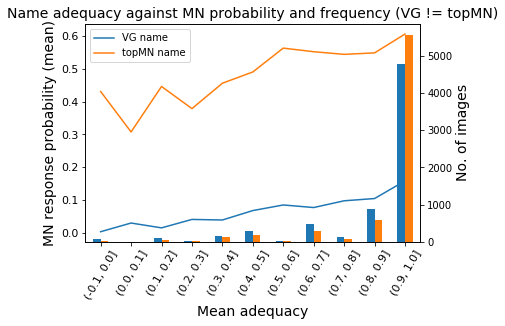

In [37]:
fig = plt.figure() 
ax = fig.add_subplot(111) 
ax2 = ax.twinx()

datastats_dfunc.plot(kind='line', 
                     ax=ax,
                     x="mean_adequacy", 
                     y=["VG name", "topMN name"], 
                     fontsize=11,
                     xticks=[0,1,2,3,4,5,6,7,8,9],
                     rot=60)
datastats_dfunc.plot(kind='bar', 
                     ax=ax2,
                     x="mean_adequacy", y=["VG name bin size", "topMN bin size"],
                    legend=None)

ax.set_ylabel('MN response probability (mean)', size=14)
ax.set_xlabel("Mean adequacy", size=14)
ax.set_title("Name adequacy against MN probability and frequency (VG != topMN)", size=14)
ax2.set_ylabel('No. of images', size=14)

plt.show()

Text(0, 0.5, 'MN response probability (mean)')

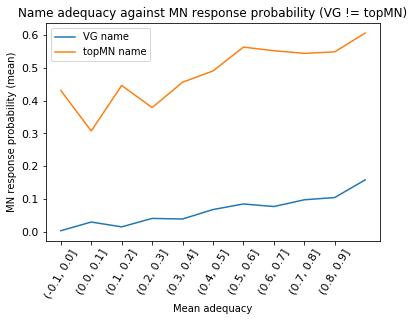

In [38]:
ax = datastats_dfunc.plot(kind='line', x="mean_adequacy", y=["VG name", "topMN name"], 
                     fontsize=11,
                     xticks=[0,1,2,3,4,5,6,7,8,9],
                     rot=60,
                     title="Name adequacy against MN response probability (VG != topMN)")
ax.set_xlabel("Mean adequacy")
ax.set_ylabel("MN response probability (mean)")

## Adequacy against response probability: All names (count > 1)

In [65]:
all_stats = [] # mean_adequacy --> mean_mn_probability
all_stats_notTop = [] # mean_adequacy --> mean_mn_probability
topMN_stats = []
for (_, row) in manynames.iterrows():
    mn_nameProbs = relfrequ(row['spellchecked_min2'])
    topMN = row['spellchecked'].most_common()[0][0]
    for (name,prob) in mn_nameProbs.items():
        adequacy_name = row['adequacy_mean'][name]
        all_stats.append((adequacy_name, prob))
        if name == topMN:
            topMN_stats.append((adequacy_name, prob))
        else:
            all_stats_notTop.append((adequacy_name, prob))

In [66]:
all_func_vals, all_bin_sizes = func_adequacy_probability(all_stats)
notTop_func_vals, notTop_bin_sizes = func_adequacy_probability(all_stats_notTop)
topMN_func_vals, topMN_bin_sizes = func_adequacy_probability(topMN_stats)

In [67]:
datastats_dfunc_all = pd.DataFrame()
datastats_dfunc_all["mean_adequacy"] = [str(a) for a in np.array(all_func_vals)[:,0]]
datastats_dfunc_all["MN name (all)"] = np.array(all_func_vals)[:,1]
datastats_dfunc_all["MN name (wo topMN)"] = np.array(notTop_func_vals)[:,1]
datastats_dfunc_all["MN name (topMN)"] = np.array(topMN_func_vals)[:,1]

datastats_dfunc_all["MN bin size (all)"] = np.array(all_bin_sizes)[:,1]
datastats_dfunc_all["MN bin size (wo topMN)"] = np.array(notTop_bin_sizes)[:,1]
datastats_dfunc_all["MN bin size (topMN)"] = np.array(topMN_bin_sizes)[:,1]

In [68]:
datastats_dfunc_all

,mean_adequacy,MN name (all),MN name (wo topMN),MN name (topMN),MN bin size (all),MN bin size (wo topMN),MN bin size (topMN)
0,"(-0.1, 0.0]",0.0892501,0.0869996,0.430481,1221,1213,8
1,"(0.0, 0.1]",0.0925409,0.0798849,0.307692,18,17,1
2,"(0.1, 0.2]",0.0996902,0.0946913,0.487504,3929,3879,50
3,"(0.2, 0.3]",0.101654,0.0932265,0.469664,402,393,9
4,"(0.3, 0.4]",0.107955,0.0998796,0.464965,6284,6145,139
5,"(0.4, 0.5]",0.127886,0.10568,0.524602,4754,4502,252
6,"(0.5, 0.6]",0.191854,0.124528,0.562148,65,55,10
7,"(0.6, 0.7]",0.203466,0.123954,0.605421,3397,2836,561
8,"(0.7, 0.8]",0.231281,0.139791,0.559204,408,319,89
9,"(0.8, 0.9]",0.242533,0.132418,0.611883,5212,4015,1197


In [69]:
print(datastats_dfunc_all["MN bin size (wo topMN)"].iloc[9]/sum(datastats_dfunc_all["MN bin size (wo topMN)"]))
print(sum(datastats_dfunc_all["MN bin size (wo topMN)"].iloc[0:9])/sum(datastats_dfunc_all["MN bin size (wo topMN)"]))

0.08513390301308284
0.4104874790610886


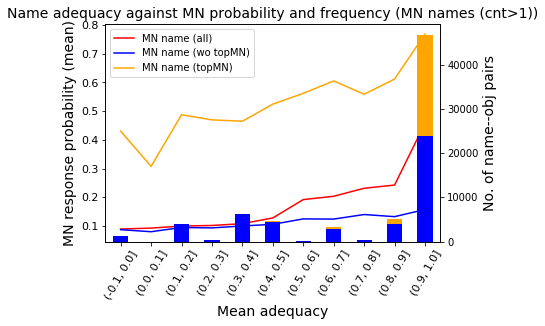

In [70]:
fig2 = plt.figure() 
ax3 = fig2.add_subplot(111) 
ax4 = ax3.twinx()

datastats_dfunc_all.plot(kind='line', 
                     ax=ax3, color=["r", "b", "orange"],
                     x="mean_adequacy", 
                     y=["MN name (all)",
                        "MN name (wo topMN)", 
                        "MN name (topMN)",], 
                     fontsize=11,
                     xticks=[0,1,2,3,4,5,6,7,8,9],
                     rot=60)
datastats_dfunc_all.plot(kind='bar', stacked=True,
                     ax=ax4, color=["b", "orange"],
                     x="mean_adequacy", y=[#"MN bin size (all)", 
                                           "MN bin size (wo topMN)", 
                                           "MN bin size (topMN)"],
                    legend=None)

ax3.set_ylabel('MN response probability (mean)', size=14)
ax3.set_xlabel("Mean adequacy", size=14)
ax3.set_title("Name adequacy against MN probability and frequency (MN names (cnt>1))", size=14)
ax4.set_ylabel('No. of name--obj pairs', size=14)

plt.show()

### Histogram of mean adequacy scores

Text(0, 0.5, 'No. of name--obj pairs')

<Figure size 432x288 with 0 Axes>

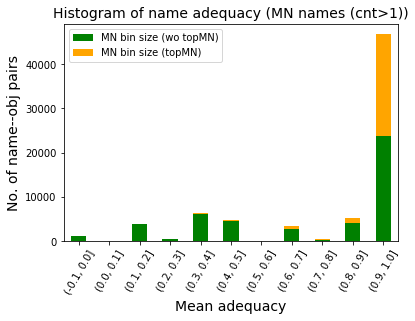

In [71]:
fig3 = plt.figure() 
ax5 = datastats_dfunc_all.plot(kind='bar', stacked=True,
                     color=["g", "orange"],
                     xticks=[0,1,2,3,4,5,6,7,8,9],
                     x="mean_adequacy", y=[#"MN bin size (all)", 
                                           "MN bin size (wo topMN)", 
                                           "MN bin size (topMN)"],
                    rot=60)

ax5.set_xlabel("Mean adequacy", size=14)
ax5.set_title("Histogram of name adequacy (MN names (cnt>1))", size=14)
ax5.set_ylabel('No. of name--obj pairs', size=14)

## Probability against mean adequacy

In [72]:
all_func_vals, all_bin_sizes = func_probability_adequacy(all_stats)
notTop_func_vals, notTop_bin_sizes = func_probability_adequacy(all_stats_notTop)
topMN_func_vals, topMN_bin_sizes = func_probability_adequacy(topMN_stats)

In [73]:
datastats_dfunc_all = pd.DataFrame()
datastats_dfunc_all["mean_probability"] = [str(a) for a in np.array(all_func_vals)[:,0]]
datastats_dfunc_all["MN name (all)"] = np.array(all_func_vals)[:,1]
datastats_dfunc_all["MN name (wo topMN)"] = np.array(notTop_func_vals)[:,1]
datastats_dfunc_all["MN name (topMN)"] = np.array(topMN_func_vals)[:,1]

datastats_dfunc_all["MN bin size (all)"] = np.array(all_bin_sizes)[:,1]
datastats_dfunc_all["MN bin size (wo topMN)"] = np.array(notTop_bin_sizes)[:,1]
datastats_dfunc_all["MN bin size (topMN)"] = np.array(topMN_bin_sizes)[:,1]

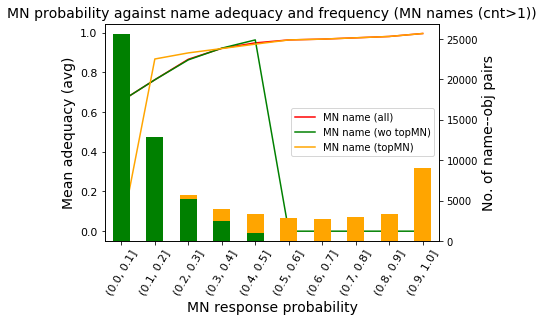

In [74]:
fig2 = plt.figure() 
ax3 = fig2.add_subplot(111) 
ax4 = ax3.twinx()

datastats_dfunc_all.plot(kind='line', 
                     ax=ax3, color=["r", "g", "orange"],
                     x="mean_probability", 
                     y=["MN name (all)",
                        "MN name (wo topMN)",
                        "MN name (topMN)",], 
                     fontsize=11,
                     xticks=[0,1,2,3,4,5,6,7,8,9],
                     rot=60)
datastats_dfunc_all.plot(kind='bar', stacked=True,
                     ax=ax4, color=["g", "orange"],
                     x="mean_probability", y=[#"MN bin size (all)", 
                                           "MN bin size (wo topMN)", 
                                           "MN bin size (topMN)"],
                    legend=None)

ax3.set_ylabel('Mean adequacy (avg)', size=14)
ax3.set_xlabel("MN response probability", size=14)
ax3.set_title("MN probability against name adequacy and frequency (MN names (cnt>1))", size=14)
ax4.set_ylabel('No. of name--obj pairs', size=14)

plt.show()